**Model Free Environment**

In [ ]:
%load_ext autoreload
%autoreload 2
from PIL import Image
import os
import sys
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random

LOCAL_PATH = os.getcwd()
# print(os.listdir(LOCAL_PATH))
sys.path.append(LOCAL_PATH)
sys.path.append(LOCAL_PATH + '/lib')

# from brid_env import *

# import time
# os.environ["TZ"] = "US/Eastern"
# time.tzset()

import numpy as np


['.config', 'sample_data']


In [220]:
import gym
from gym import spaces
import numpy as np
import sys
import io

class BirdEnv(gym.Env):
    def __init__(self):

        """ 
            Initializes a cliff walking gridworld environemnt.
        """
        self.ini_reserve = 6
        self.S = self.ini_reserve
        # Initial reserve is the energy reserve to begin with
        # The consideration behind taking energy reserve as a state dimension is that we can not only access whether the agent is risk-prone or -averse
        # but also how such preference might change according to the current energy the agent has 
        # So the agent might develop different risk preference (which is policy) when having different energy reserve
        self.cap = 30 # max energy capacity
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(self.cap)
        self.p = [0.5,0.5] # probability of each outcome in the risk choice
        self.energy_consumption = {   # energy consumption defiend by the temperature
                    'warm': -1 ,
                    'cold': -3 ,
                }
        self.uni_reward = False # universal reward for each step
        self.risk_reward = [0,6]
        self.safe_reward = 2
        # begin in start state
        self.reset()

    def step(self,action,temperature):

        """ 
            Defines environment step function.
        """
        self.transition = [0,0]
        # transition function
        self.transition[0] = self.safe_reward # safe action
        self.transition[1] = np.random.choice(self.risk_reward, p=list(self.p)) # risky action
        # transition to new state.
        self.S += self.energy_consumption[temperature] # comsume energy at every step
        self.S += self.transition[action] # the current energy reserve

        # the max capacity of energy reserve is defined by the width
        self.S = min(self.S, self.cap-1)

        # check if we reached terminal state
        if self.S <= 0:
            return self.S, -10, True, {} # the penalty for dying is -10
        else:
            if self.uni_reward:
                return self.S, 1, False, {} # the reward of surviving each step is one
            else: 
                return self.S, self.S, False, {} # the reward of surviving each step is according to current energy reserve
    def reset(self):
        self.S = self.ini_reserve
        return self.S
env = BirdEnv()

**Model Based Environment**

Markov Decision Process

In [231]:
T_risk_w = np.zeros((env.cap+1,env.cap+1)) # transition function for risk choice in warm environment
T_risk_w[0,0] = 1
for i in range(1,env.cap+1):
    if i + env.energy_consumption['warm'] <= 0:
        T_risk_w[i,0] = 1
    else:
        if i < (env.cap - max(env.risk_reward)-env.energy_consumption['warm']):
            T_risk_w[i,i+min(env.risk_reward)+env.energy_consumption['warm']] += env.p[0]
            T_risk_w[i,i+max(env.risk_reward)+env.energy_consumption['warm']] += env.p[1]
        else: 
            T_risk_w[i,i+min(env.risk_reward)+env.energy_consumption['warm']] += env.p[0]
            T_risk_w[i,env.cap] += env.p[1]

T_safe_w = np.zeros((env.cap+1,env.cap+1)) # transition function for safe choice in warm environment
T_safe_w[0,0] = 1
for i in range(1,env.cap+1):
    if i + env.energy_consumption['warm'] <= 0:
        T_safe_w[i,0] = 1
    else:
        if i < (env.cap - env.safe_reward-env.energy_consumption['warm']):
            T_safe_w[i,i+env.safe_reward+env.energy_consumption['warm']] += 1
        else: 
            T_safe_w[i,env.cap] += 1

T_w=np.array([T_safe_w,T_risk_w]) # transition function in warm environment

T_risk_c = np.zeros((env.cap+1,env.cap+1)) # transition function for risk choice in cold environment
T_risk_c[0,0] = 1
for i in range(1,env.cap+1):
    if i + env.energy_consumption['cold'] <= 0:
        T_risk_c[i,0] = 1
    else:
        if i < (env.cap - max(env.risk_reward)-env.energy_consumption['cold']):
            T_risk_c[i,i+min(env.risk_reward)+env.energy_consumption['cold']] += env.p[0]
            T_risk_c[i,i+max(env.risk_reward)+env.energy_consumption['cold']] += env.p[1]
        else: 
            T_risk_c[i,i+min(env.risk_reward)+env.energy_consumption['cold']] += env.p[0]
            T_risk_c[i,env.cap] += env.p[1]

T_safe_c = np.zeros((env.cap+1,env.cap+1)) # transition function for safe choice in cold environment
T_safe_c[0,0] = 1 
for i in range(1,env.cap+1):
    if i + env.energy_consumption['cold'] <= 0:
        T_safe_c[i,0] = 1
    else:
        if i < (env.cap - env.safe_reward-env.energy_consumption['cold']):
            T_safe_c[i,i+env.safe_reward+env.energy_consumption['cold']] += 1
        else: 
            T_safe_c[i,env.cap] += 1

T_c=np.array([T_safe_c,T_risk_c]) # transition function in cold environment

In [232]:
R_u = np.zeros((env.cap+1,env.cap+1)) # universal reward
R_u[:,0] = -10
R_u[:,range(1,env.cap+1)] = 1

R_e = np.zeros((env.cap+1,env.cap+1)) # energy reward
R_e[:,0] = -10
R_e[:,range(1,env.cap+1)] = range(1,env.cap+1)

In [ ]:
# def mdp(steps, policy, T, R):
#     state = [env.ini_reserve]
#     action = []
#     reward = []
#     for i in range(steps):
#         s_i = state[i]
#         pi_i = policy[s_i]
#         a_i = np.random.choice([0,1], p=list(pi_i))
#         t_i = T[a_i,s_i]
#         s_ii = np.random.choice(list(range(env.cap+1)), p=list(t_i))
#         r_i = R[s_i,s_ii]
#         state.append(s_ii)
#         action.append(a_i)
#         reward.append(r_i)
#     return state, action, reward
def policy_eval(pi, states, T, R, gamma=1.0):
    V = np.zeros(env.cap+1)
    while True:
        delta = 0
        delta_stable = False
        # For each state, perform a "full backup"
        for s in states: # enumerates over all our possible states
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(pi[s]): # enumerates over actions for a given state
                v += action_prob * np.dot(T[a,s],(R[s] + gamma * V)) 
                # I skipped the enumeration of every outcome and just used dot product
            delta_i = delta
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v # storing 
        if np.abs(delta_i - delta) <= 0.1: # if we are picking the best actions, stop.
            delta_stable = True
        if delta_stable:
            break
    return np.array(V)


In [ ]:
def one_step_lookahead(s, V, T, R):
        A = np.zeros(len(T))
        for a in range(len(T)):
            A[a] += np.dot(T[a,s],(R[s] + 1 * V)) 
        return A

In [ ]:
def policy_improvement(states, T, R, n_episode, policy_eval_fn=policy_eval, gamma=1.0):
    
    def one_step_lookahead(s, V, T, R):
        A = np.zeros(len(T))
        for a in range(len(T)):
            A[a] += np.dot(T[a,s],(R[s] + gamma * V)) 
        return A
    
    # Start with a random policy
    policy = np.ones([len(R), len(T)]) / len(T)
    
    for i in range(n_episode):
        # Evaluate the current policy
        V = policy_eval_fn(policy, states, T, R)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(len(R)):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V, T, R)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            policy[s] = np.eye(len(T))[best_a]
        # print(policy)
        # If the policy is stable we've found an optimal policy, ends the improvement and we return. 
        
    return policy

**Q-learning**

In [ ]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])  # policy is implicitly represented by the Q values.
        A[best_action] += (1.0 - epsilon) # allowing the possibility of exploration (epsilon) and not exploitation (1s)
   
        return A
    return policy_fn

def Q_learn(epsilon, alpha, discount_factor, temperature, universal_reward, env):
    Q = np.zeros((env.cap,env.action_space.n)) # at each energy reserve, there are two choices to choose from
    n_episodes = 1000 
    n_max_timesteps = 30
    R_q_agent = [] 
    T_q_agent = []
    D_q_agent = []
    for i_episode in range(n_episodes):
      
      # Reset environment at the beginning of each episode. 
        state = env.reset()

        done = False

        t = 0 # timestep counter
        ep_return = 0 # cliff penalty and return counters

        # Loop through time steps. 
        while not done:
          
            # Pick an action. 
            ############################ 
            ### E-GREEDY POLICY HERE ###
            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            ############################ 

            # Step through and observe new state and reward. 
            ##########################
            ### STEP FUNCTION HERE ###
            state = env.S
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs) 
            next_state, reward, done, _ = env.step(action,temperature)
            ##########################

            ###########################
            ### Q-VALUE UPDATE HERE ###
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action] 
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            ###########################

            # Update counters.
            ep_return += reward
            t += 1
            if done:
                death = 1
            else: 
                death = 0
            # Break the loop if we haven't finished the episode in the 
            # max amount of time. 
            if t == n_max_timesteps:
                done = True

            # Check if we reached the terminal state. 
            if done:
                R_q_agent.append(ep_return)
                T_q_agent.append(t)
                D_q_agent.append(death)
                break

    env.close()
    return Q, R_q_agent, T_q_agent, D_q_agent

**SARSA-learning**

In [ ]:
def SARSA_learn(epsilon, alpha, discount_factor, temperature, universal_reward, env):
    Q = np.zeros((env.cap,env.action_space.n)) # at each energy reserve, there are two choices to choose from
    n_episodes = 1000 
    n_max_timesteps = 30
    R_s_agent = [] 
    T_s_agent = []
    D_s_agent = []
    for i_episode in range(n_episodes):
      
        # Reset environment at the beginning of each episode. 
        state = env.reset()

        done = False

        t = 0 # timestep counter
        ep_return = 0 # cliff penalty and return counters

        # Loop through time steps. 
        while not done:
          
            # Pick an action. 
            ############################ 
            ### E-GREEDY POLICY HERE ###
            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            ############################ 

            # Step through and observe new state and reward. 
            ##########################
            ### STEP FUNCTION HERE ###
            state = env.S
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs) 
            next_state, reward, done, _ = env.step(action,temperature)
            ##########################

            ###########################
            ### UPDATE HERE ###
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            td_target = reward + discount_factor * Q[next_state][next_action] 
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            ###########################

            # Update counters.
            ep_return += reward
            t += 1
            if done:
                death = 1
            else: 
                death = 0
            # Break the loop if we haven't finished the episode in the 
            # max amount of time. 
            if t == n_max_timesteps:
                done = True

            # Check if we reached the terminal state. 
            if done:
                R_s_agent.append(ep_return)
                T_s_agent.append(t)
                D_s_agent.append(death)
                break

    env.close()
    return Q, R_s_agent, T_s_agent, D_s_agent

**Reward based on current energy reserve**

In [ ]:
def risk_av(Q,env): # a algorithm to test how risk averse the agents are in their policies
    diffs = np.zeros(env.cap)
    for i in range(env.cap):
        if np.abs(Q[i][0]) + np.abs(Q[i][1]) == 0:
            diff = 0
        else:
            diff = (Q[i][0] - Q[i][1]) / (np.abs(Q[i][0]) + np.abs(Q[i][1]))
    diffs[i] = diff
    return diffs

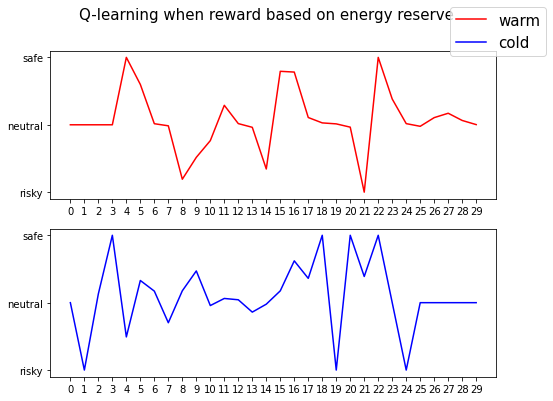

In [278]:
Q_warm, R_q_warm, T_q_warm, D_q_warm = Q_learn(0.1,0.5,1,'warm',False,env)
Q_cold, R_q_cold, T_q_cold, D_q_cold = Q_learn(0.1,0.5,1,'cold',False,env)
risk_w = risk_av(Q_warm,env)
risk_c = risk_av(Q_cold,env)
fig, axs = plt.subplots(2,figsize=(8,6))
fig.suptitle('Q-learning when reward based on energy reserve',fontsize=15)
axs[0].plot(list(range(env.cap)), risk_w,'r',label='warm')
axs[1].plot(list(range(env.cap)), risk_c,'b',label='cold')
axs[0].set_xticks(list(range(env.cap)))
axs[1].set_xticks(list(range(env.cap)))
axs[0].set_yticks([-1,0,1])
axs[1].set_yticks([-1,0,1])
axs[0].set_yticklabels(['risky','neutral','safe'])
axs[1].set_yticklabels(['risky','neutral','safe'])
fig.legend(loc='upper right',fontsize=15)
plt.show()

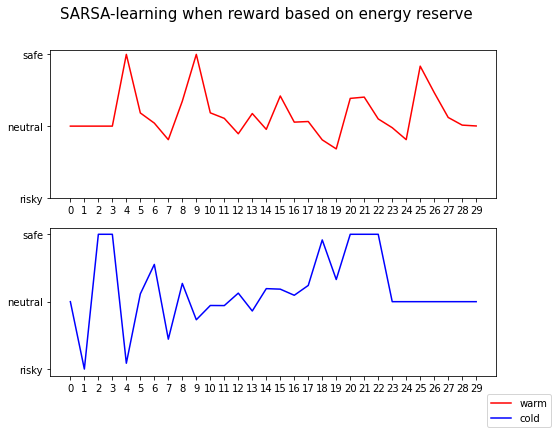

In [252]:
S_warm, R_s_warm, T_s_warm, D_s_warm = SARSA_learn(0.1,0.5,1,'warm',False,env)
S_cold, R_s_cold, T_s_cold, D_s_cold = SARSA_learn(0.1,0.5,1,'cold',False,env)
risk_w = risk_av(S_warm,env)
risk_c = risk_av(S_cold,env)
fig, axs = plt.subplots(2,figsize=(8,6))
fig.suptitle('SARSA-learning when reward based on energy reserve',fontsize=15)
axs[0].plot(list(range(env.cap)), risk_w,'r',label='warm')
axs[1].plot(list(range(env.cap)), risk_c,'b',label='cold')
axs[0].set_xticks(list(range(env.cap)))
axs[1].set_xticks(list(range(env.cap)))
axs[0].set_yticks([-1,0,1])
axs[1].set_yticks([-1,0,1])
axs[0].set_yticklabels(['risky','neutral','safe'])
axs[1].set_yticklabels(['risky','neutral','safe'])
fig.legend(loc='lower right')
plt.show()

In [238]:
policy = np.empty((4,env.cap+1,2))
policy[0] = policy_improvement(range(env.cap+1), T_w, R_u, 500)
policy[1] = policy_improvement(range(env.cap+1), T_c, R_u, 500)
policy[2] = policy_improvement(range(env.cap+1), T_w, R_e, 500)
policy[3] = policy_improvement(range(env.cap+1), T_c, R_e, 500)


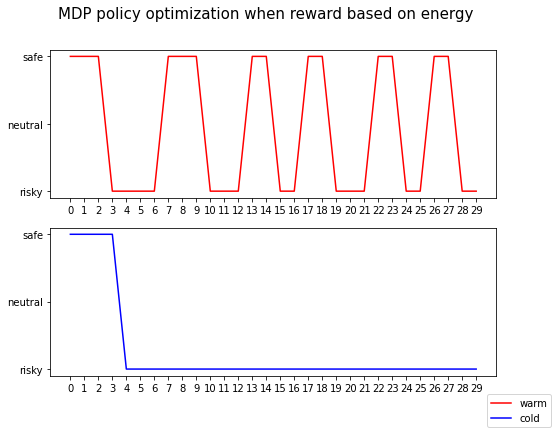

In [241]:
risk_w_e = risk_av(policy[2],env)
risk_c_e = risk_av(policy[3],env)

fig, axs = plt.subplots(2,figsize=(8,6))
fig.suptitle('MDP policy optimization when reward based on energy',fontsize=15)
axs[0].plot(list(range(env.cap)), risk_w_e,'r',label='warm')
axs[1].plot(list(range(env.cap)), risk_c_e,'b',label='cold')
axs[0].set_xticks(list(range(env.cap)))
axs[1].set_xticks(list(range(env.cap)))
axs[0].set_yticks([-1,0,1])
axs[1].set_yticks([-1,0,1])
axs[0].set_yticklabels(['risky','neutral','safe'])
axs[1].set_yticklabels(['risky','neutral','safe'])
fig.legend(loc='lower right')
plt.show()

**Reward based on surviving time**

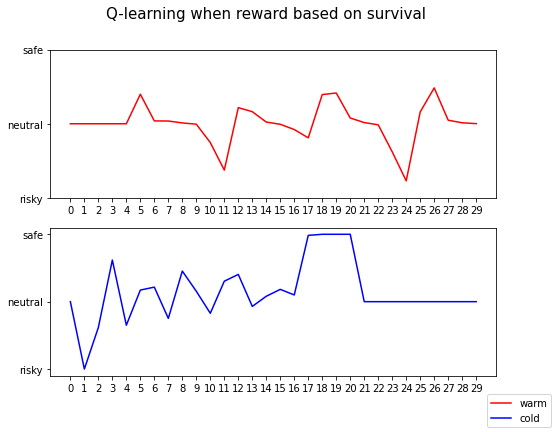

In [259]:
Q_warm, R_q_warm, T_q_warm, D_q_warm = Q_learn(0.1,0.5,1,'warm',True,env)
Q_cold, R_q_cold, T_q_cold, D_q_cold = Q_learn(0.1,0.5,1,'cold',True,env)
risk_w = risk_av(Q_warm,env)
risk_c = risk_av(Q_cold,env)
fig, axs = plt.subplots(2,figsize=(8,6))
fig.suptitle('Q-learning when reward based on survival',fontsize=15)
axs[0].plot(list(range(env.cap)), risk_w,'r',label='warm')
axs[1].plot(list(range(env.cap)), risk_c,'b',label='cold')
axs[0].set_xticks(list(range(env.cap)))
axs[1].set_xticks(list(range(env.cap)))
axs[0].set_yticks([-1,0,1])
axs[1].set_yticks([-1,0,1])
axs[0].set_yticklabels(['risky','neutral','safe'])
axs[1].set_yticklabels(['risky','neutral','safe'])
fig.legend(loc='lower right')
plt.show()

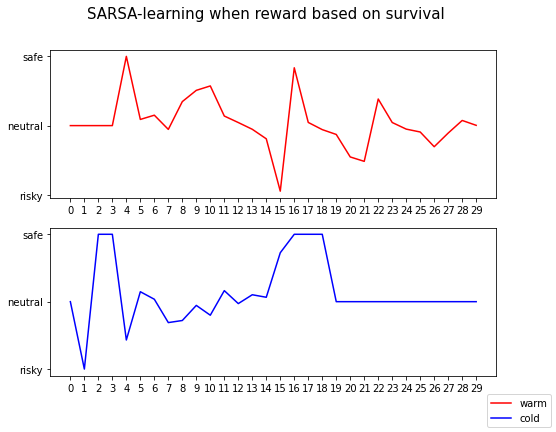

In [260]:
S_warm, R_s_warm, T_s_warm, D_s_warm = SARSA_learn(0.1,0.5,1,'warm',True,env)
S_cold, R_s_cold, T_s_cold, D_s_cold = SARSA_learn(0.1,0.5,1,'cold',True,env)
risk_w = risk_av(S_warm,env)
risk_c = risk_av(S_cold,env)
fig, axs = plt.subplots(2,figsize=(8,6))
fig.suptitle('SARSA-learning when reward based on survival',fontsize=15)
axs[0].plot(list(range(env.cap)), risk_w,'r',label='warm')
axs[1].plot(list(range(env.cap)), risk_c,'b',label='cold')
axs[0].set_xticks(list(range(env.cap)))
axs[1].set_xticks(list(range(env.cap)))
axs[0].set_yticks([-1,0,1])
axs[1].set_yticks([-1,0,1])
axs[0].set_yticklabels(['risky','neutral','safe'])
axs[1].set_yticklabels(['risky','neutral','safe'])
fig.legend(loc='lower right')
plt.show()

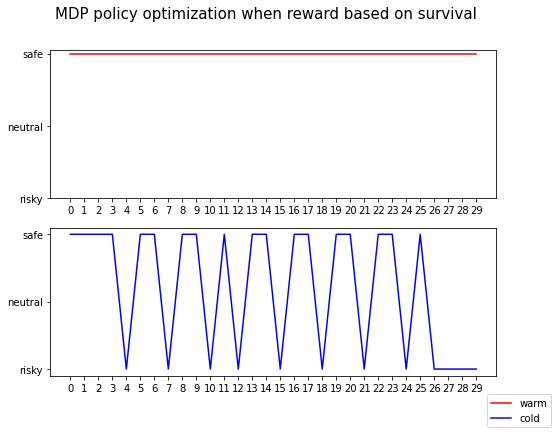

In [261]:
risk_w_u = risk_av(policy[0],env)
risk_c_u = risk_av(policy[1],env)

fig, axs = plt.subplots(2,figsize=(8,6))
fig.suptitle('MDP policy optimization when reward based on survival',fontsize=15)
axs[0].plot(list(range(env.cap)), risk_w_u,'r',label='warm')
axs[1].plot(list(range(env.cap)), risk_c_u,'b',label='cold')
axs[0].set_xticks(list(range(env.cap)))
axs[1].set_xticks(list(range(env.cap)))
axs[0].set_yticks([-1,0,1])
axs[1].set_yticks([-1,0,1])
axs[0].set_yticklabels(['risky','neutral','safe'])
axs[1].set_yticklabels(['risky','neutral','safe'])
fig.legend(loc='lower right')
plt.show()